This notebook is by Anastasia Ruzmaikina.

Here we analyse a dataset of nearly 5000 movies. The goal is to be able to predict if a movie is profitable given all the information available about the movie. The available data columns are the title, names of actors and actresses, movie genres, vote count, movie budget etc.

In this notebook we use the Decision Tree Classifier to predict if a movie is profitable.

After fine tuning the hyperparameters of the Decision Tree Classifier, we can predict if a movie is profitable with accuracy 77.4%.

In [63]:
# Data manipulation
import numpy as np 
import pandas as pd

# Data Visualazation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import statsmodels.api as sm

import random
import scipy.optimize

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

We download the Movie Dataset from the Harvard Edx website.

In [64]:
df = pd.read_csv("https://courses.edx.org/asset-v1:HarvardX+PH526x+2T2019+type@asset+block@movie_data.csv", index_col=0)

df

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...",...,2787965087,162.0,"English, Español",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",...,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24",...,880674609,148.0,"Français, English, Español, Italiano, Deutsch",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra..."
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",...,1084939099,165.0,English,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,...,284139100,132.0,English,Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"Action, Crime, Thriller",NaN,9367,"united states–mexico barrier, legs, arms, pape...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,Columbia Pictures,...,2040920,81.0,Español,Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,9367,"Carlos Gallardo, Jaime de Hoyos, Peter Marquar..."
4799,9000,"Comedy, Romance",NaN,72766,NaN,en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,NaN,...,0,85.0,NaN,Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5,72766,"Edward Burns, Kerry Bishé, Marsha Dietlein, Ca..."
4800,0,"Comedy, Drama, Romance, TV Movie",http://www.hallmarkchannel.com/signedsealeddel...,231617,"date, love at first sight, narration, investig...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"Front Street Pictures, Muse Entertainment Ente...",...,0,120.0,English,Released,NaN,"Signed, Sealed, Delivered",7.0,6,231617,"Eric Mabius, Kristin Booth, Crystal Lowe, Geof..."
4801,0,NaN,http://shanghaicalling.com/,126186,NaN,en,Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,NaN,...,0,98.0,English,Released,A New Yorker in Shanghai,Shanghai Calling,5.7,7,126186,"Daniel Henney, Eliza Coupe, Bill Paxton, Alan ..."


We can look at the shape of the data set:

In [65]:
df.shape

(4803, 22)

We replace infinite values with NaN values in the data frame. NaN values are handled later.



In [66]:
df = df.replace(to_replace = np.inf, value = np.nan)
df = df.replace(to_replace = -np.inf, value = np.nan)

Next we do a one hot encoding of the 'genres' column.

First we identify how many different genres are present in the 'genres' column.

We split the genres into different columns. Each column contains 1's or 0's, one if that particlar genre is present in that row.



In [67]:
genr = []
for i in range(len(df['genres'])):
    temp = df['genres'].iloc[i]
    if not (isinstance(temp, float)):
       temp = temp.split(',')
       genr += temp
       
genre = list(set(genr))
for i in range(len(genre)):
    genre[i] = genre[i].strip()
genre = list(set(genre))
for item in genre:
    df[item] = df['budget']
for item in genre:
    for i in range(len(df['genres'])):
        if not (isinstance(df['genres'].iloc[i], float)):
             if item in df['genres'].iloc[i]:
                   df[item].iloc[i] = 1
             else:
                   df[item].iloc[i] = 0

We create a new column indicating if a movie is profitable.

The 'profitable' column is the difference between 'revenue' and 'budget' column.



In [68]:
df['profitable'] = df['revenue']
for i in range(len(df['revenue'])):
    if df['revenue'].iloc[i] >= df['budget'].iloc[i]:
        df['profitable'].iloc[i] = 1
    else:
        df['profitable'].iloc[i] = 0

In [69]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,Documentary,History,Foreign,TV Movie,Science Fiction,Romance,War,Western,Comedy,profitable
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...",...,0,0,0,0,1,0,0,0,0,1
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",...,0,0,0,0,0,0,0,0,0,1
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24",...,0,0,0,0,0,0,0,0,0,1
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",...,0,0,0,0,0,0,0,0,0,1
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,...,0,0,0,0,1,0,0,0,0,1


Descriptive Statistics.

Before solving the problem, it's very important to have a good understanding of data.

First we get the descriptive statistics of the data.

Then we get the information about missing values in the data

In [70]:
# Info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4775 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4391 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4452 non-null   object 
 10  production_countries  4629 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4716 non-null   object 
 15  status               

In [71]:
# Summary statistic of the data
df.describe()  

,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id,Thriller,Adventure,...,Documentary,History,Foreign,TV Movie,Science Fiction,Romance,War,Western,Comedy,profitable
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000,4803.000000,4.803000e+03,4.803000e+03,...,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989,57165.484281,7.706173e+02,7.705166e+02,...,7.703750e+02,7.703931e+02,7.703592e+02,7.703537e+02,7.704635e+02,7.705382e+02,7.703821e+02,7.703691e+02,7.707106e+02,0.723923
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891,88694.614033,3.441408e+04,3.441408e+04,...,3.441409e+04,3.441409e+04,3.441409e+04,3.441409e+04,3.441408e+04,3.441408e+04,3.441409e+04,3.441409e+04,3.441408e+04,0.447102
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000,9014.500000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000,14629.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000,58610.500000,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,459488.000000,2.000000e+06,2.000000e+06,...,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,1.000000


In [72]:
# Get count of missing values in every column
print(df.isna().sum())

budget                     0
genres                    28
homepage                3091
id                         0
keywords                 412
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies     351
production_countries     174
release_date               1
revenue                    0
runtime                    2
spoken_languages          87
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
movie_id                   0
cast                      43
Thriller                   0
Adventure                  0
Fantasy                    0
Crime                      0
Family                     0
Horror                     0
Animation                  0
Action                     0
Mystery                    0
Music                      0
Drama                      0
Documentary                0
History       

Conclusions:

The data contains some categorical columns, these columns need to be handled before building the model.

Some columns have missing values, these need to be handled before building the model. Since the columns with missing values are categorical, we are not going to have a problem with dropping them.

The y variable (profitable) doesn't have any missing values, which is good.



Now we list the numeric and categorical columns.

In [73]:
# Create list of numeric and categorical columns and check if they have extra spaces in the column names
num_col = df.select_dtypes(include=np.number).columns
print("Numerical columns: \n",num_col)

cat_col = df.select_dtypes(exclude=np.number).columns
print("Categorical columns: \n",cat_col)

Numerical columns: 
 Index(['budget', 'id', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count', 'movie_id', 'Thriller', 'Adventure', 'Fantasy', 'Crime',
       'Family', 'Horror', 'Animation', 'Action', 'Mystery', 'Music', 'Drama',
       'Documentary', 'History', 'Foreign', 'TV Movie', 'Science Fiction',
       'Romance', 'War', 'Western', 'Comedy', 'profitable'],
      dtype='object')
Categorical columns: 
 Index(['genres', 'homepage', 'keywords', 'original_language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'spoken_languages', 'status', 'tagline', 'title',
       'cast'],
      dtype='object')


We already did one hot encoding on the 'genres' column, so we can drop the 'genres' column.

The only categorical column that can influence the 'profitable' column is the 'cast' column. But if we do a one hot encoding, we find that we need a hundred or more columns. Therefore it is impractical to use 'cast' data and we are going to drop the 'cast' column.

All other categorical columns have very little influence on the revenue from the movie, so we can drop them.

In addition we are going to drop the 'revenue' column, because it is linearly dependent on the related 'profitable' column we are going to predict.

We are going to drop the columns 'id' and 'movie_id', because they carry no information.

In [74]:
df = df.drop(columns=['genres', 'homepage', 'keywords', 'original_language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'spoken_languages', 'status', 'tagline', 'title',
       'cast', 'revenue', 'id', 'movie_id'])
df = df.dropna()
print(df.shape)

(4801, 26)


As a result of dropping categorical columns and the revenue column, only two rows remained with NaN values, when they were droppped the data frame has 4801 rows left.

In [75]:
df.head()

,budget,popularity,runtime,vote_average,vote_count,Thriller,Adventure,Fantasy,Crime,Family,...,Documentary,History,Foreign,TV Movie,Science Fiction,Romance,War,Western,Comedy,profitable
0,237000000,150.437577,162.0,7.2,11800,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,300000000,139.082615,169.0,6.9,4500,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,245000000,107.376788,148.0,6.3,4466,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,250000000,112.312950,165.0,7.6,9106,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,260000000,43.926995,132.0,6.1,2124,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1


Exploratory data analysis is an approach to analyze or investigate data sets to find out patterns and see if any of the variables can be useful in predicting the y variables. Visual methods are often used to summarise the data. Primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing tasks.

We are going to:

Check the distribution of target variable

Check the correlation between different features

Check the relation between different features

We can plot a pie chart for the distribution of values in the 'profitable' column.



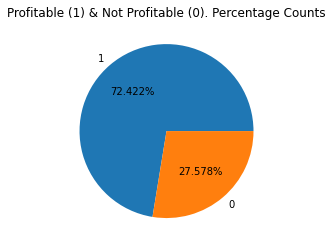

In [76]:
# get the set of distinct classes
labels = df.profitable.unique()

# get the count of each class
sizes = df.profitable.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Profitable (1) & Not Profitable (0). Percentage Counts')
plt.show()

We look at the 'profitable' column as a function of 'budget'.

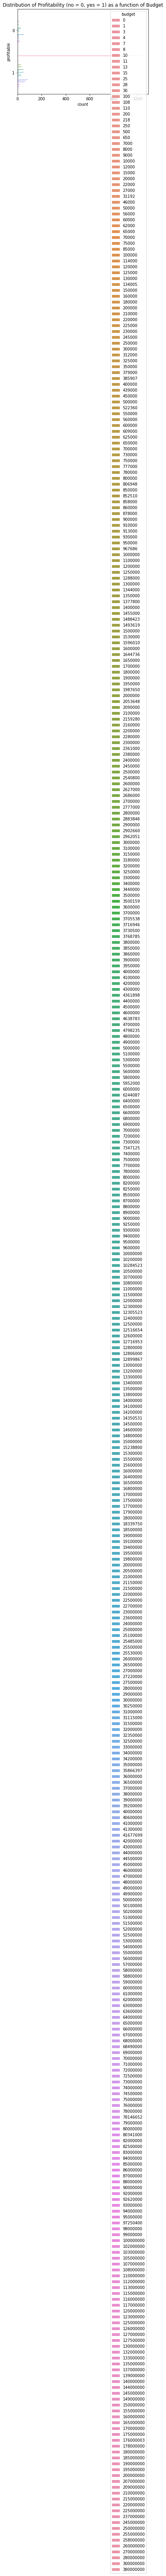

In [77]:
sns.countplot(y='profitable', data=df, hue='budget')
plt.title("Distribution of Profitability (no = 0, yes = 1) as a function of Budget")
plt.show()

We look at the 'profitable' column as a function of 'vote_average'.

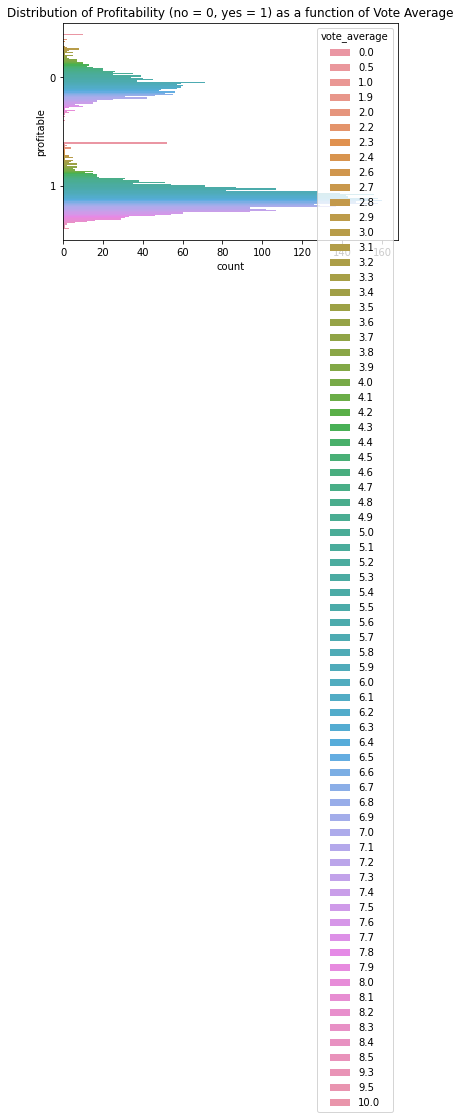

In [78]:
sns.countplot(y='profitable', data=df, hue='vote_average')
plt.title("Distribution of Profitability (no = 0, yes = 1) as a function of Vote Average")
plt.show()

We look at the 'profitable' column as a function of 'vote_count'.

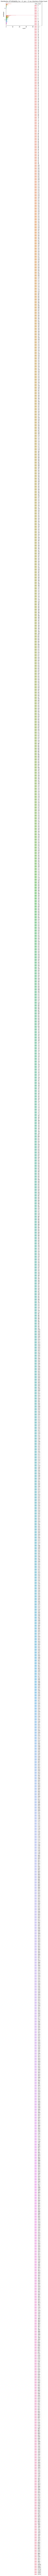

In [79]:
sns.countplot(y='profitable', data=df, hue='vote_count')
plt.title("Distribution of Profitability (no = 0, yes = 1) as a function of Vote Count")
plt.show()

Data preprocessing

In [80]:
df.columns

Index(['budget', 'popularity', 'runtime', 'vote_average', 'vote_count',
       'Thriller', 'Adventure', 'Fantasy', 'Crime', 'Family', 'Horror',
       'Animation', 'Action', 'Mystery', 'Music', 'Drama', 'Documentary',
       'History', 'Foreign', 'TV Movie', 'Science Fiction', 'Romance', 'War',
       'Western', 'Comedy', 'profitable'],
      dtype='object')

First we rescale the data in the first five columns using the Standard Scaler to make sure that the columns with higher values do not have a disproportionate effect on the target variable.

We assign the first 25 columns a predictors X, and the 26th column 'profitable' as a target variable y.

In [81]:
# data preprocessing such as scaling/normalization is typically useful for 
# linear models to accelerate the training convergence

# standardize features by removing the mean and scaling to unit variance
df.iloc[:, 0:6] = StandardScaler().fit_transform(df.iloc[:, 0:6])
data_matrix = df.values

# X: feature matrix (for this analysis, we exclude the 'high_value' variable from the dataset)
X = data_matrix[:, 0:25]

# y: labels vector
y = data_matrix[:, 25]

# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

df.head()

X.shape= (4801, 25) y.shape= (4801,)


,budget,popularity,runtime,vote_average,vote_count,Thriller,Adventure,Fantasy,Crime,Family,...,Documentary,History,Foreign,TV Movie,Science Fiction,Romance,War,Western,Comedy,profitable
0,5.106231,4.052434,2.438088,0.929025,8.998200,-0.022399,1,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,6.653231,3.695551,2.747691,0.677213,3.085524,-0.022399,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,5.302675,2.699047,1.818881,0.173591,3.057985,-0.022399,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,5.425453,2.854189,2.570775,1.264773,6.816180,-0.022370,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,5.671009,0.704839,1.111217,0.005717,1.161069,-0.022399,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1


We split the data into the training set and the test set.

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)       
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (3360, 25) Y_train.shape= (3360,)
X_test.shape= (1441, 25) Y_test.shape= (1441,)


Let's take a look at the training data set.

In [83]:
X_train

array([[ 0.41136422,  0.08726963,  0.1630678 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.14858994, -0.07411451,  0.13010767, ...,  0.        ,
         0.        ,  0.        ],
       [-0.11356373, -0.00184687,  0.18383134, ...,  0.        ,
         0.        ,  0.24271871],
       ...,
       [-0.11334833,  0.01854579, -0.11145469, ...,  0.        ,
         0.        ,  0.        ],
       [-0.13653367, -0.11412777,  0.12838896, ...,  0.        ,
         0.        ,  0.20552191],
       [-0.20002525, -0.07454132, -0.1707773 , ...,  0.        ,
         0.        ,  0.        ]])

Model Building

Parameters

1.max_depth: (int, default=None) This is used to select how deep you want to make each tree in the forest. The deeper the tree, the more splits it has, and it captures more information about the data.

2.criterion :{“Gini,” “entropy”}, default=” Gini”: Measures the quality of each split. “Gini” uses the Gini impurity while “entropy” makes the split based on the information gain.

3.splitter:{“best”, “random”}, default=”best” The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

4.min_samples_split: (int or float, default=2:) This specifies the minimum number of samples that must be present from your data for a split to occur.

Decision Tree Model 1:

We import the Decision Tree Classifier and build the first model. We take the max tree depth to be 4 and the splitting criterion to be based on the Gini Impurity.

In [84]:
# compute the sample weights to be used as input to the train routine so that 
# it takes into account the class imbalance present in this dataset
w_train = compute_sample_weight('balanced', y_train)

# import the Decision Tree Classifier Model from scikit-learn
from sklearn.tree import DecisionTreeClassifier

# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35, criterion='gini',
                                splitter='random')

# train a Decision Tree Classifier using scikit-learn
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  0.00478


We compare the predicted values of y using X_test with y_test and calculate ROC-AUC score as well as the Accuracy Score.



In [85]:
# run inference and compute the probabilities of the test samples 
# to belong to the class of high-quality wines
sklearn_pred = sklearn_dt.predict_proba(X_test)[:,1]

# evaluate the Compute Area Under the Receiver Operating Characteristic 
# Curve (ROC-AUC) score from the predictions
sklearn_roc_auc = roc_auc_score(y_test, sklearn_pred)
print('[Scikit-Learn] ROC-AUC score : {0:.3f}'.format(sklearn_roc_auc))
print('The Accuracy Score:', sklearn_dt.score(X_test,y_test))

[Scikit-Learn] ROC-AUC score : 0.728
The Accuracy Score: 0.6932685634975712


Predict values using trained model 1

In [86]:
# Predicting the test and trained values
y_train_pred = sklearn_dt.predict(X_train)
y_test_pred = sklearn_dt.predict(X_test)
print('Prediction of training data 0:100 is:', y_train_pred[0:100])
print('Prediction of test data 0:100 is:', y_test_pred[0:100])

Prediction of training data 0:100 is: [1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1.
 0. 0. 1. 1.]
Prediction of test data 0:100 is: [1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1.
 1. 1. 1. 1.]


Model 1 Performance.

We measure the performance using the confusion matrix and the accuracy score.

In [87]:
# Importing all the required metrics for calculating Accuracy
from sklearn.metrics import accuracy_score, confusion_matrix

In [88]:
confusion_matrix(y_train, y_train_pred)

array([[ 567,  360],
       [ 665, 1768]])

In [89]:
confusion_matrix(y_test, y_test_pred)

array([[231, 166],
       [276, 768]])

In [90]:
# The Accuracy_score
accuracy_score(y_test, y_test_pred)

0.6932685634975712

Decision Tree Model 2

We increase max depth to 5, use 'entropy' as a splitting criterion.



In [91]:
#storing the Decision tree classifier into clftree2
clftree2 = DecisionTreeClassifier(max_depth = 5, criterion = "entropy",
                                  splitter = "best")
clftree2.fit(X_train, y_train)
clftree2.score(X_test,y_test)

0.7578070784177654

Decision Tree Model 3

We increase max depth to 6, use 'gini' as a splitting criterion.

In [92]:
#storing the Decision tree classifier into clftree3
clftree3 = DecisionTreeClassifier(max_depth = 6, criterion = "gini", 
                                  splitter = "random")
clftree3.fit(X_train, y_train)
clftree3.score(X_test,y_test)

0.7175572519083969

Decision Tree Model 4

We increase max depth to 6, use 'entropy' as a splitting criterion.

In [93]:
#storing the Decision tree classifier into clftree4
clftree4 = DecisionTreeClassifier(max_depth = 6, criterion = "entropy", 
                                  splitter = "best")
clftree4.fit(X_train, y_train)
clftree4.score(X_test,y_test)

0.768910478834143

Decision Tree Model 5

We increase max depth to 7, use 'entropy' as a splitting criterion.

In [111]:
#storing the Decision tree classifier into clftree5
clftree5 = DecisionTreeClassifier(max_depth = 7, criterion = "entropy", 
                                  splitter = "best")
clftree5.fit(X_train, y_train)
clftree5.score(X_test,y_test)

0.7744621790423317

Hyperparameter Tuning using GridSearchCV:

In order to find optimal parameters, we do a grid search over different parameter values.

Parameters

1.max_depth: (int, default=None) This is used to select how deep you want to make each tree in the forest. The deeper the tree, the more splits it has, and it captures more information about the data.

2.criterion :{“Gini,” “entropy”}, default=” Gini”: Measures the quality of each split. “Gini” uses the Gini impurity while “entropy” makes the split based on the information gain.

3.splitter:{“best”, “random”}, default=”best” The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

4.min_samples_split: (int or float, default=2:) This specifies the minimum number of samples that must be present from your data for a split to occur.

One traditional and popular way to perform hyperparameter tuning is by using an Exhaustive Grid Search from Scikit learn. This method tries every possible combination of each set of hyper-parameters. Using this method, we can find the best set of values in the parameter search space. This usually uses more computational power and takes a long time to run since this method needs to try every combination in the grid size.

In [95]:
# Importing GridsearchCV
from sklearn.model_selection import GridSearchCV

In [104]:
# Assigning all the parameters of Decision tree classifier for  parameters variable
parameters ={
    'max_depth': [3,4,5,6,7,8,9,11,13],
    'criterion':['gini','entropy'],
    'splitter':['random','best'],
    'min_samples_split':[2,4,6,7,8,9, 10, 11, 12, 13, 14, 15],
    }

In [105]:
# Assigning parameters for GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(),parameters, scoring='accuracy', verbose=2, cv=3,)

In [106]:
# Fitting the model into gridsearchCV
grid_result= grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] END criterion=gini, max_depth=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=4, splitter=best; total time=  

[CV] END criterion=gini, max_depth=4, min_samples_split=8, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_split=8, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_split=8, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_split=9, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_split=9, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_split=9, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=4, min_samples_split=10, s

[CV] END criterion=gini, max_depth=5, min_samples_split=11, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=11, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=11, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=11, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=11, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=11, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=12, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=12, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=12, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=12, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_sample

[CV] END criterion=gini, max_depth=6, min_samples_split=15, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=7, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=7, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=7, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=7, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=7, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=7, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=7, min_samples_split=4

[CV] END criterion=gini, max_depth=8, min_samples_split=8, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=8, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=8, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=9, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=9, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=9, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=10, s

[CV] END criterion=gini, max_depth=9, min_samples_split=11, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=9, min_samples_split=11, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=9, min_samples_split=11, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=9, min_samples_split=11, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=9, min_samples_split=11, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=9, min_samples_split=12, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=9, min_samples_split=12, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=9, min_samples_split=12, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=9, min_samples_split=12, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=9, min_samples_split=12, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=9, min_samples_

[CV] END criterion=gini, max_depth=11, min_samples_split=15, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=13, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=13, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=13, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=13, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=13, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=13, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=13, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=13, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=13, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=13, min_samp

[CV] END criterion=entropy, max_depth=3, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_split=11, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_split=11, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_split=11, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, min_samples_split=11, splitter=best; total time=   0.0s
[CV] END criterion

[CV] END criterion=entropy, max_depth=4, min_samples_split=15, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_split=15, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_split=15, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, m

[CV] END criterion=entropy, max_depth=6, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, min_samples_split=8, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, min_samples_split=8, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, min_samples_split=8, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, min_samples_split=8, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, min_samples_split=8, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, min_samples_split=8, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=entropy, 

[CV] END criterion=entropy, max_depth=7, min_samples_split=12, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, min_samples_split=12, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, min_samples_split=12, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, min_samples_split=13, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, min_samples_split=13, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, min_samples_split=13, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, min_samples_split=13, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, min_samples_split=13, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, min_samples_split=13, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, min_samples_split=14, splitter=random; total time=   0.0s
[CV] END criterion=ent

[CV] END criterion=entropy, max_depth=8, min_samples_split=14, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=8, min_samples_split=14, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=8, min_samples_split=15, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=8, min_samples_split=15, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=8, min_samples_split=15, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=8, min_samples_split=15, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=8, min_samples_split=15, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=8, min_samples_split=15, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=ent

[CV] END criterion=entropy, max_depth=11, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=11, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=11, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=11, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=11, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=11, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=11, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=11, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=11, min_samples_split=8, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=11, min_samples_split=8, splitter=random; total time=   0.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=13, min_samples_split=8, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_split=8, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_split=9, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_split=9, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_split=9, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion

best_index_: (int) The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

In [107]:
print('Best index: ', grid_result.best_index_)

Best index:  247


best_params (dict): Parameter setting that gave the best results on the hold out data.

In [108]:
print('Best Params: ', grid_result.best_params_)

Best Params:  {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 7, 'splitter': 'best'}


best_score (float) : Mean cross-validated score of the best_estimator

For multi-metric evaluation, this is present only if refit is specified.

This attribute is not available if refit is a function.

In [109]:
print('Best Score: ', grid_result.best_score_)

Best Score:  0.7735119047619049


We now show a graph of what the decision tree looks like.

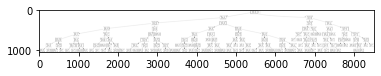

In [110]:
import pandas
from sklearn import tree
import pydotplus
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.image as pltimg

#tree.plot_tree(Tree)
import graphviz
features = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count',
       'Thriller', 'Adventure', 'Fantasy', 'Crime', 'Family', 'Horror',
       'Animation', 'Action', 'Mystery', 'Music', 'Drama', 'Documentary',
       'History', 'Foreign', 'TV Movie', 'Science Fiction', 'Romance', 'War',
       'Western', 'Comedy']
data = tree.export_graphviz(clftree5, out_file=None, feature_names=features)
graph = pydotplus.graph_from_dot_data(data)
graph.write_png('mydecisiontree.png')

img=pltimg.imread('mydecisiontree.png')

plt.figure(figsize=(6,6))
imgplot = plt.imshow(img)
plt.show()


Conclusion: Using the Decision Tree Classifier, we can predict if the movie is profitable with accuracy 77.4%.